# P03: Nonlinear Oscillators

* Last revision: 25-Nov-2020 by Heiko Hergert (hergert@frib.msu.edu)
* Oscillator GUI based on code by Dick Furnstahl (furnstahl.1@osu.edu).

# 1. Introduction

Dynamical systems that are governed by nonlinear differential equations frequently exhibit **chaotic** behavior: Infinitesimal differences in the initial conditions are amplified such that they can lead to a radically different time evolution in phase space. Consequently, predicting the long-term behavior of a nonlinear dynamical system is difficult at best, and often impossible.

In this project, we will study the dynamics of a nonlinear oscillator in phase space, introducing some useful visualization tools for chaotic systems along the way.

**Task**: 

1. Start by going over the notebook and testing out the GUI and other routines for the driven and damped harmonic oscillator, which is currently implemented.

</div>

# 2. The Duffing Oscillator

The model we will study is the so-called **Duffing oscillator**, which is defined by the Hamiltonian
$$
  H(q,p) = \frac{p^2}{2m} - \frac{1}{2}m\omega^2_0q^2 + \frac{1}{4}\alpha q^4\,,
$$
where $a$ is a real constant. Note the sign of the quadratic term! 


<div class="alert alert-block alert-info">

**Task**: 

2.1. Plot the potential. 
2.2. Derive Hamilton's equations. 
2.3. Add the usual viscous damping and a periodic driving force to the dynamical equations. Why do we add these terms to the equation for $\dot{p}$ (cf. reference implementation of the standard harmonic oscillator)? 
</div>

### 2.1 Plotting the Potential

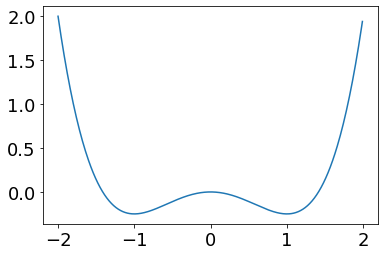

In [37]:
import numpy as np
import matplotlib.pyplot as plt

q = np.arange(-2,2,0.01)
plt.plot(q,-1/2 * q**2 + 1/4 * q**4)
plt.show()

### 2.2 Deriving Hamilton's Equations

\begin{align*}
    \dot{q} = \frac{\partial H}{\partial p} &= \frac{p}{m},\\
    \dot{p} = -\frac{\partial H}{\partial q} &= m\omega_0 q - \alpha q^3.
\end{align*}

### 2.3 Adding Damping and Driving Forces

\begin{align*}
    \dot{p} \rightarrow \dot{p} &= m\omega_0 q - \alpha q^3 - \beta \dot{q}^2 + A_0 \sin(\omega_d t).
\end{align*}

Since the derivative of momentum is equal to the net force on an object, all one needs to do is add more forces into the sum to modify it in the way we want.
Nothing else needs to change.

# 3. Implementation

### A Word on Code Organization
The present notebook makes use of a widget-based GUI to explore the parameters of our dynamical model. To reduce clutter, I have moved the graphical user interface elements to a separate module *p03_oscillator_gui.py*. The appropriate routines are imported below. 

<div class="alert alert-block alert-info">

**Task**: 

Implement the Duffing oscillator in the oscillator class. *Note:* You'll have to account for the additional parameter $\alpha$ in the plot function **and add a slider to the GUI in the external module** (you can simply follow the example of the already implemented parameters). 
</div>

In [17]:
%matplotlib inline

In [26]:
import numpy as np
from scipy.integrate import ode, odeint

from numpy import fft

from abc import ABC, abstractmethod

import matplotlib.pyplot as plt

## 3.1 Class Definitions

Here we provide the class definitions for our oscillator model, and define some helper functions. 

### Oscillator

In [19]:
class Oscillator():
    """
     A generic oscillator class that implements the parameters and Hamilton's equations.
     
    Parameters
    ----------
    omega0 : float
        natural frequency of the oscillator (e.g., \sqrt{k/m} if a spring) 
    beta : float
        coefficient of damping term (with a factor of 2) 
    f_ext, omega_ext, phi_ext : float
        parameters of the external driving force

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
        
    driving_force(t)
        Returns the external driving force at time t.
    """
    def __init__(self,
                 m=1.,
                 omega0=1.,
                 beta=0.2,
                 f_ext = 0.,
                 omega_ext = 0.,
                 phi_ext = 0.
                ):
        self.m = m
        self.omega0 = omega0
        self.beta = beta
        self.f_ext = f_ext
        self.omega_ext = omega_ext
        self.phi_ext = phi_ext
    
    def driving_force(self, t):
        """
        This function computes the size of the driving force at time t.
        
        Parameters
        ----------
        t : float
            time 
                    
        """
        return self.f_ext * np.cos(self.omega_ext * t + self.phi_ext)

    def energy(self, y, t):
        """
        This function computes the energy at t.
        
        Parameters
        ----------
        y : float
            A 2-component vector with y[0] = q(t) and y[1] = p

        t : float
            time 
                    
        """
        q, p = y
        energy = p**2/(2*self.m) + 0.5 * self.m * self.omega0**2 * q**2 
        return energy

    
    
    def dy_dt(self, y, t):
        """
        This function returns the right-hand side of the diffeq as a vector: 
        [dq/dt 
         dp/dt ]
        
        Parameters
        ----------
        y : float
            A 2-component vector with y[0] = q(t) and y[1] = p
        t : float
            time 
                    
        """
        dqdt = y[1] / self.m
        dpdt =  - self.m * self.omega0**2*y[0] - 2*self.beta*y[1] + self.driving_force(t)
        return [dqdt, dpdt ]


## 3.2 Helpers

The generic plot function from before.

In [20]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    # prevent the ranges from getting too small
    dx = abs(np.max(x) - np.min(x)) 
    dy = abs(np.max(y) - np.min(y)) 
    cx = 0.5*(np.max(x) + np.min(x))
    cy = 0.5*(np.max(y) + np.min(y))
    if dx < 1.0e-5: plt.xlim(cx - 1.0e-5, cx + 1.0e-5)
    if dy < 1.0e-5: plt.ylim(cy - 1.0e-5, cy + 1.0e-5)

    line, = ax.plot(x, y, label=label, color=color, linestyle=linestyle)
    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line


## 3.3 Main plot function

The main plot function for use in the GUI's `interactive_output`.

In [43]:
def osci_plots(q_vs_time_plot=True, p_vs_time_plot=True, 
             phase_space_plot=True, driving_curve=True,
             energy_plot=True, poincare_plot=True,
             omega0=10.*np.pi, beta=np.pi/2., 
             f_ext=0, omega_ext=0, phi_ext=0,
             q0=0.0, p0=0.0, 
             t_start=0, t_end=10, delta_t=0.01, plot_start=0,
             font_size=18,
             controls=None):
    """
    Create plots for interactive_output according to the inputs.
    
    Based on generating a Harmonic_oscillator instance and associated graphs.
    
    Notes
    -----
        1. We generate a new oscillator instance every time *and* 
            solve the ODE every time, even if the only change is to parameters
            like t_start and t_end.  Should we care or is this just so
            cheap to recalculate that it doesn't matter?
            How could we structure this differently?
        2. Should we delete ho1 at some point, e.g., could there be a memory issue? 
            In principle, Python should call the destructor once an object's reference
            count goes to zero, right?
    """
    
    # Set up mesh for time integration: We use either fractions of the driving force's period,
    # the oscillator's natural period, or a default step size (useful for Poincare map).

    # add delta_t it goes at least to t_end    
    if abs(omega_ext) > 1.0e-5:
        delta_t = 2 * np.pi / omega_ext / 100.
    elif abs(omega0) > 1.0e-5:
        delta_t = 2 * np.pi / omega0 / 100.
    else:
        # allow override ?
        delta_t = 0.01

    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  
        
    # Instantiate an oscillator with the passed (or default) values of the 
    #  natural frequency omega0, damping beta and driving force.
    osci = Oscillator(omega0=omega0, beta=beta, f_ext=f_ext, omega_ext=omega_ext, phi_ext=phi_ext)
    y0 = [q0, p0]  # initial conditions for the oscillator ODE

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # For now we solve with odeint; give more options in the future.
    #  The .T is for transpose, so that the matrix from odeint can changed
    #  to the correct form for reading off q and p.
    q, p = odeint(osci.dy_dt, y0, t_pts,
                              atol=abserr, rtol=relerr).T
    
    # also calculate the driving force for the same t_pts
    driving = osci.driving_force(t_pts)
        
    # Update the common font size
    plt.rcParams.update({'font.size': font_size})
 
    # Labels for individual plot axes
    q_vs_time_labels = (r'$t$', r'$q$')
    p_vs_time_labels = (r'$t$', r'$p$')
    phase_space_labels = (r'$q$', r'$p$')
    energy_plot_labels = (r'$t$', r'$E$')

    
    # Figure out how many rows and columns [two rows for now]
    plot_flags = [q_vs_time_plot, p_vs_time_plot, phase_space_plot, energy_plot, poincare_plot]
    plot_num = plot_flags.count(True)
    plot_rows = 2
    figsize_rows = plot_rows*6
    plot_cols = 2
    figsize_cols = min(plot_cols*8, 16)  # at most 16
    
    # Make the plot!
    fig = plt.figure(figsize=(figsize_cols,figsize_rows))
    #     , axes = plt.subplots(plot_rows, plot_cols,
    # Do not delete the empty slot before the comma in this line, it's important!
    , axes = plt.subplots(plot_rows, plot_cols)
                             
    # finds nearest index to plot_start in t_pts array                      
    start_index = (np.fabs(t_pts-plot_start)).argmin() 
    
    next_axis = 1  # keep track of the axis number
    if q_vs_time_plot:
        ax_q = fig.add_subplot(plot_rows, plot_cols, next_axis)                  
        plot_y_vs_x(t_pts, q, axis_labels=q_vs_time_labels, 
                    label='oscillator', title=r'$q$ vs. time', 
                    ax=ax_q)    
        # add a line where the phase space plot starts
        ax_q.axvline(t_pts[start_index], lw=3, color='red')
                          
        if driving_curve:
           ax_driving = ax_q.twinx()
           plot_y_vs_x(t_pts, driving, ax=ax_driving, color='red',
                       linestyle='dotted')      # add 'driving label?'                   
        next_axis += 1
    
    if p_vs_time_plot:
        ax_p = fig.add_subplot(plot_rows, plot_cols, next_axis)                  
        plot_y_vs_x(t_pts, p, axis_labels=p_vs_time_labels, 
                    label='oscillator', title=r'$p$ vs. time', 
                    ax=ax_p)    
        # add a line where the phase space plot starts
        ax_p.axvline(t_pts[start_index], lw=3, color='red')
                          
        if driving_curve:
           ax_driving2 = ax_p.twinx()
           plot_y_vs_x(t_pts, driving, ax=ax_driving2, color='red',
                       linestyle='dotted')  # add 'driving label?'                        
        next_axis += 1

    if phase_space_plot:
        ax_phase_space = fig.add_subplot(plot_rows, plot_cols, next_axis)                  
        plot_y_vs_x(q[start_index:-1], p[start_index:-1], 
                    axis_labels=phase_space_labels, title='Phase space', 
                    ax=ax_phase_space)    
        next_axis += 1

    if energy_plot:
        EE = osci.energy([q,p], t_pts)
                          
        ax_energy_plot = fig.add_subplot(plot_rows, plot_cols, next_axis)                  
        plot_y_vs_x(t_pts, EE, 
                    axis_labels=energy_plot_labels, title='Energy', 
                    ax=ax_energy_plot)    
        next_axis += 1

    if poincare_plot:
        ax_poincare_plot = fig.add_subplot(plot_rows, plot_cols, next_axis)
        ax_poincare_plot.set_xlabel(phase_space_labels[0])
        ax_poincare_plot.set_ylabel(phase_space_labels[1])
        ax_poincare_plot.set_xlim(np.min(q), np.max(q))
        ax_poincare_plot.set_ylim(np.min(p), np.max(p))
        ax_poincare_plot.set_title('Poincare map')
        ax_poincare_plot.scatter(q[start_index::100], p[start_index::100], s=8, lw=2)
        next_axis += 1
        
        print("("+str(q[start_index::100][-1])+","+str(p[start_index::100][-1])+")")
                          
    fig.tight_layout()
        
    return fig



# 4. Exploring the Model

# 4.1 Response to Parameter Variations
Finally, we call the GUI from the external Python module. It groups the controls in the following tabs:
* On the main tab (`Physics`), you can use the sliders to vary the initial conditions and the parameters of the model.
* The `Plotting` tab controls which plots are shown (see discussion above) and controls the start and end times for the integration as well the size of the time step (only used if no frequencies `omega0` or `omega_ext` are defined, see `osci_plot`). Use `Start plotting` to remove initial segments of the solution to eliminate transient behavior from the plots.
* The `Styling` tab only controls the size of font labels at this time.

<div class="alert alert-block alert-info">

    
The GUI can produce standard plots like $q(t)$, $p(t)$, or $E(t)$ versus time. More interesting are the phase space plots and the **Poincaré map**. The former is a 2D plot of $(q(t), p(t))$, and it can be used to classify the different types of dynamical behavior: closed trajectories like for a free harmonic oscillator, spiraling for damped or driven oscillators, emergence of fixed points, limit cycles, or chaos. 
    
The Poincaré map is another useful tool for visualizing the dynamics. It consists of the points $(q(n*T), p(n*T))$, where $T$ is a characteristic period of the system (e.g., the period of the driving force or the natural frequency of the oscillator). **Which period should you use to generate the Poincaré map for a damped and driven Duffing oscillator? Why?** 
    
    
**Task**: 

Find examples for fixed points, limit cycles, and chaotic behavior. Explain why the Poincaré map looks the way it does in these cases. Document your results using screenshots or by generating and saving figures by calling `osci_plot` with appropriate parameters and saving the result:
    
```
    fig = osci_plot(alpha=..., omega_ext=..., ...)
    fig.savefig('<An appropriate name>.pdf', format='pdf', bbox_inches='tight')
```
    
**Note:** I recommend starting the oscillator from rest at (or near) one of the minima of the potential and ramping up  $f_\text{ext}$ in small steps while keeping the other parameters fixed. (Also see next section.) **Use the `start plotting` slider to eliminate the initial transient behavior of the system.**

</div>

I don't know what you mean, when asking which period should I use to generate the Poincaré map. It looks like any period can be used.
Why is one period able to generate the map better than another?

When you say fixed points, does that mean the points on the Poincaré map converge to a single point, that point beinga fixed point? If that's the case, then one such point is $(q\approx 0, p\approx 1/3)$.
The numbers used to produce this point are
\begin{align*}
    q_0 &= 0 \text{ m},\\
    p_0 &= 0 \text{ kg m s$^{-1}$},\\
    \omega_0 &= 2\text{ Hz},\\
    \omega_{ext} &= 2\text{ Hz},\\
    f_{ext} &= 1\text{ N},\\
    \phi_{ext} &= 0\text{ rad},\\
    \beta &= 1.5.
\end{align*}

A quick look up of what limit cycles are tells me that these numbers also produce a limit cycle, so that's cool.

I'm having a lot of trouble finding chaotic motion. Sorry.

In [44]:
# from p03_oscillator_gui import OscillatorGUI, float_widget
from IPython.display import display
    
gui = OscillatorGUI(plotfunction=osci_plots)

display(gui.vbox)



# 4.2 Bifurcation
The following routine creates a **bifurcation** diagram for the model: The positions of $q(n*T_\text{ext})$ at multiples of the period of the driving force are plotted vs. the strength `f_ext`. Again, we use `t_drop` to prevent the initial transient behavior from being included in the plot: It is recommended to drop about $1000\cdot T$. **Please note that generating the diagram can take some time, especially if you use many sampling points.**

In [45]:
# This function generates the main output here, which is a grid of plots
def bifurcation(f_ext_min=0, f_ext_max=2, f_sample=200,
             omega0=1., beta=0.05, alpha=1., omega_ext=1.4, phi_ext=0,
             q0=0.0, p0=0.0, t_start=0, t_end=8000, t_drop=5000,
            ):
    """
    Create a bifurcation plot of the model by plotting all q(n*T) for a given value of the
    driving force strength (T: period of the driving force). 
    
    f_ext_min, f_ext_max, f_sample: (float)
            Interval of f_ext values that is swept by the routine. f_sample is the number of
            (equidistant) sample points.
            
    omega0, beta, omega_ext, phi_ext: (float)
            Parameters of the model. (Extend as needed.)
            
    q0, p0: (float)
            Initial conditions for the integration.
            
    t_start, t_end, t_drop: (float)
            Time interval for the integration. This should be sufficiently long for the system
            to exhibit complex chaotic behavior. Data from [0, t_drop] are dropped because the
            system will usually exhibit transient behavior for some time after starting.
    """
    
    # Set up mesh for time integration: We use either fractions of the driving force's period,
    # the oscillator's natural period, or a default step size (useful for Poincare map).

    # number of steps per period
    num_steps = 100
    
    if abs(omega_ext) > 1.0e-5:
        delta_t = 2 * np.pi / omega_ext / num_steps
    elif abs(omega0) > 1.0e-5:
        delta_t = 2 * np.pi / omega0 / num_steps
    else:
        # allow override ?
        delta_t = 0.01

    # add delta_t it goes at least to t_end
    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  


    # Use this to drop the first several hundred periods or so
    start_index = (np.fabs(t_pts-t_drop)).argmin() 


    # step size for driving force
    df = abs(f_ext_max - f_ext_min) / f_sample
    
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(12,16))
    ax.set_xlabel(r'$F_\mathrm{ext}$')
    ax.set_ylabel(r'q')
    ax.set_xlim(f_ext_min - df, f_ext_max + df)
    
    f_data=[ ]
    q_data=[ ]
    for i in range(0, f_sample+1):
        f_ext = f_ext_min + i*df
        osci = Oscillator(omega0=omega0, beta=beta, f_ext=f_ext, omega_ext=omega_ext, phi_ext=phi_ext)
        y0 = [q0, p0]  # initial conditions for the oscillator ODE

        #  The .T is for transpose, so that the matrix from odeint can changed
        #  to the correct form for reading off q and p.
        q, p = odeint(osci.dy_dt, y0, t_pts, atol=abserr, rtol=relerr).T
        
        f_data.append([f_ext] * len(q[start_index::num_steps]))
        q_data.append(q[start_index::num_steps])

    ax.scatter(f_data, q_data, s=8, lw=2)

                          
    fig.tight_layout()
    
    
    return fig



<div class="alert alert-block alert-info">

**Task**: 

Generate one (or more) bifurcation diagrams that illustrates various dynamical behaviors (fixed points, limit cycles, chaos). For best results, I again recommend to start the oscillator in (or near) one of the equilibria of the potential, and to use fine-grained intervals, e.g., $f_\text{max} - f_\text{min} = 0.05$, $f_\text{sample}=100-200$.

</div>

Some comments regarding the interpretation of this diagram:
* A rapid *period doubling* is a typical indicator for the impending emergence of chaotic behavior.
* The `breaks` in the curve occur when there is a **fixed point** for the given $f_\text{ext}$ during the time interval we study. 
* If a few distinct well-separated points emerge, the system has a **limit** cycle with several characteristic frequencies (i.e., several loops in the phase space trajectory).
* Chaotic behavior is readily evident: A range of possible positions is 'smeared out' (although this may only look continuous due to the plot settings).

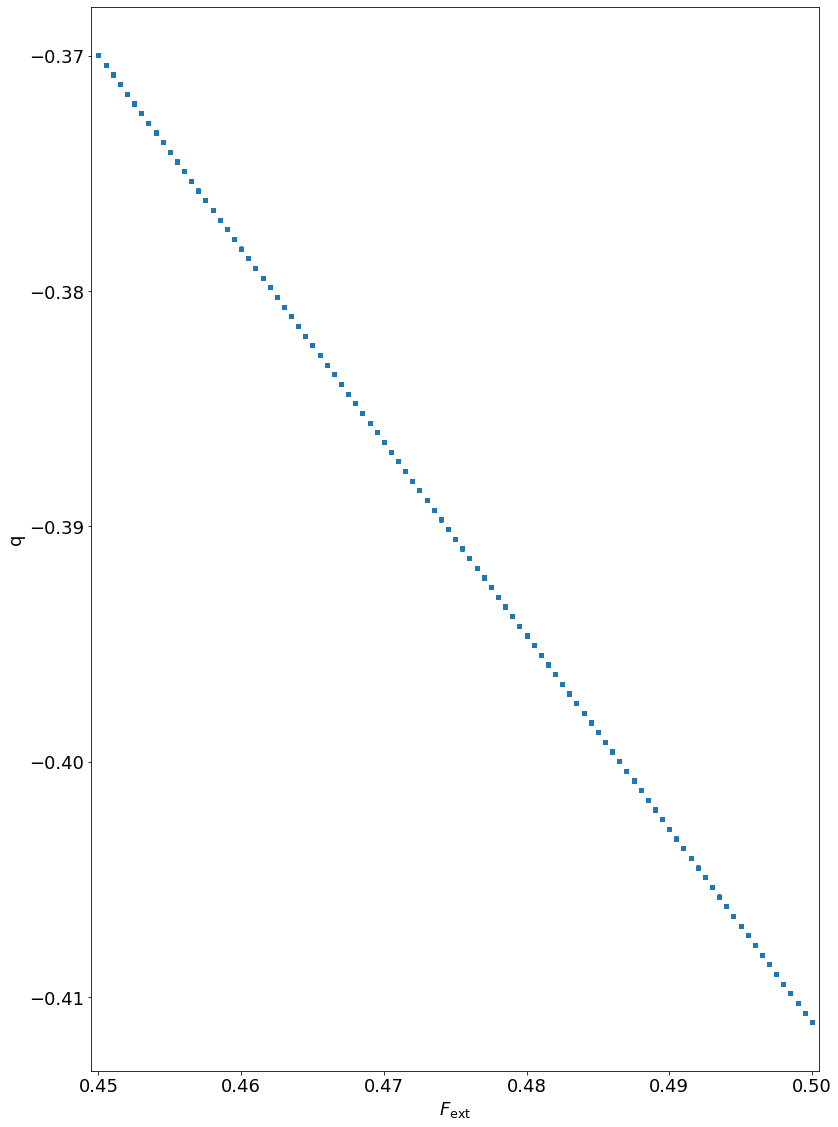

In [46]:

diag = bifurcation(f_ext_min=0.45, f_ext_max=0.5, f_sample=100, q0=-1)
diag.savefig('ho_bifucation.pdf', format='pdf', bbox_inches='tight')